In [1]:
import sys
sys.path.append('../..')
import torchvision 
from torchvision import transforms
from torch.utils.data import DataLoader
import torch as ch
import torch.nn as nn
import math
import matplotlib.pyplot as plt
import cox
from cox.utils import Parameters
import cox.store as store
from cox.readers import CollectionReader
import seaborn as sns
import os

from delphi import train
from delphi.cifar_models import vgg11
from delphi.utils import model_utils
from delphi import grad
from delphi import oracle
from delphi.utils.datasets import CIFAR
import delphi.utils.constants as consts
import delphi.utils.data_augmentation as da
from delphi.utils.helpers import setup_store_with_metadata

# set environment variable so that stores can create output files
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

# Constants

In [2]:
BASE_CLASSIFIER_PATH = '/home/pstefanou/cifar-10/resnet-18/base'

# Experiment Hyperparameters

In [3]:
args = Parameters({ 
    'epochs': 150,
    'num_workers': 8, 
    'batch_size': 128, 
    'lr': 1e-1, 
    'accuracy': True,
    'momentum': .9, 
    'weight_decay': 5e-4, 
    'save_ckpt_iters': 50,
    'should_save_ckpt': True,
    'log_iters': 1,
    'custom_lr_multiplier': consts.COSINE, 
    'validation_split': .8,
    'shuffle': True,
    'parallel': False, 
    'num_samples': 1000,
})
if ch.cuda.is_available(): 
    args.__setattr__('device', 'cuda')
args

{
  "epochs": 150,
  "num_workers": 8,
  "batch_size": 128,
  "lr": 0.1,
  "accuracy": true,
  "momentum": 0.9,
  "weight_decay": 0.0005,
  "save_ckpt_iters": 50,
  "should_save_ckpt": true,
  "log_iters": 1,
  "custom_lr_multiplier": "cosine",
  "validation_split": 0.8,
  "shuffle": true,
  "parallel": false,
  "num_samples": 1000,
  "device": "cuda"
}

# Setup and Explore Dataset

In [4]:
ds = CIFAR(data_path='/home/pstefanou/')
model, _ = model_utils.make_and_restore_model(arch='resnet18', dataset=ds)
train_loader, val_loader = ds.make_loaders(batch_size=128, workers=8)

Files already downloaded and verified
Files already downloaded and verified


label: automobile


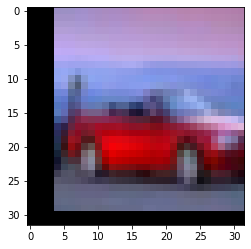

label: airplane


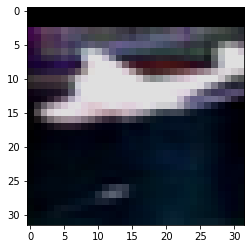

label: ship


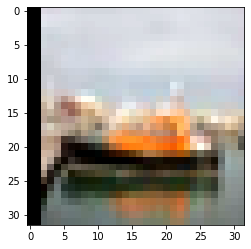

label: horse


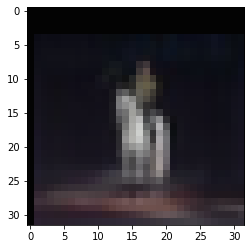

label: cat


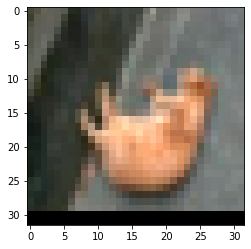

label: truck


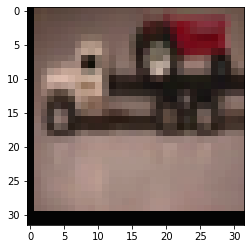

label: frog


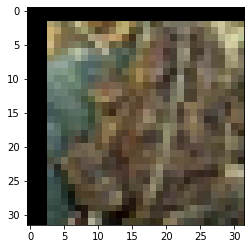

label: dog


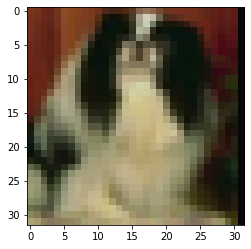

label: deer


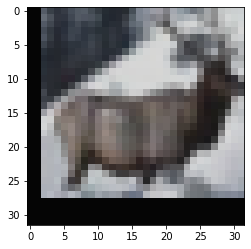

label: bird


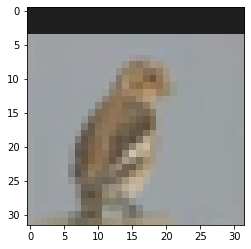

In [5]:
labels = {i for i in range(10)}
for image, target in train_loader: 
    for j in range(len(target)): 
        im, targ = image[j], target[j]
        if targ.item() in labels: 
            print("label: {}".format(da.CIFAR_LABELS[targ.item()]))
            plt.imshow(transforms.ToPILImage(mode="RGB")(im.squeeze(0)))
            plt.show()
            labels.remove(targ.item())
        if len(labels) == 0: 
            break

# Setup Store and Train Model

In [6]:
# logging store
out_store = store.Store(BASE_CLASSIFIER_PATH)
setup_store_with_metadata(args, out_store)

Logging in: /home/pstefanou/cifar-10/resnet-18/base/b78013b8-fc41-41c9-8682-763299796454


# TruncatedCE with Identity Oracle

In [20]:
# train
args.__setattr__('phi', oracle.Identity())
args.__setattr__('custom_criterion', grad.TruncatedCE)
final_model = train.train_model(args, model, (train_loader, val_loader), store=out_store, parallel=args.parallel)

KeyboardInterrupt: 

In [ ]:
reader = CollectionReader(BASE_CLASSIFIER_PATH)
metadata = reader.df('metadata')
logs = reader.df('logs')
reader.close()
logs.head()

# Accuracy and Loss Curves

In [ ]:
sns.lineplot(data=logs, x='epoch', y='val_prec1', label='val_prec1', color='b')
ax = sns.lineplot(data=logs, x='epoch', y='train_prec1', label='train_prec1', color='r')
ax.set(xlabel='Epoch', ylabel='Accuracy')
plt.show()

sns.lineplot(data=logs, x='epoch', y='val_loss', label='val_loss', color='b')
ax = sns.lineplot(data=logs, x='epoch', y='train_loss', label='train_loss', color='r')
ax.set(xlabel='Epoch', ylabel='Loss')

# Load in Model

In [ ]:
model_utils.make_and_restore_model(arch='resnet50', dataset=ds, resume_path=BASE_CLASSIFIER_PATH + '15033fc8-d094-461c-b5eb-7fef776f23ec/checkpoint.pt.best')

# Test Accuracy

In [24]:
test_store = store.Store(args.out_dir)
results = train.eval_model(args, base_model, test_loader, test_store)
results

{'test_prec1': tensor(91.1700, device='cuda:0'),
 'test_loss': 0.36373048400878905,
 'time': 1.1794376373291016}